# Urban heat Island Optimization

Libraries

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from geneticalgorithm import geneticalgorithm as ga
from scipy.ndimage import gaussian_filter, binary_dilation
from sklearn.cluster import DBSCAN
import random

Data loading

In [195]:
# ===========================
# 1. Data Loading & Preparation
# ===========================
def load_map(filename='sample_grid.csv'):
    df = pd.read_csv(filename)

    # Mapping of types to numerical values
    type_to_num = {'building': 0, 'road': 1, 'green_space': 2, 'water': 3}
    num_to_type = {v: k for k, v in type_to_num.items()}
    df['type_num'] = df['type'].map(type_to_num)

    # Creating pivot tables for types and temperatures
    type_pivot = df.pivot(index='y', columns='x', values='type_num')
    temp_pivot = df.pivot(index='y', columns='x', values='temp_fac')

    # Sort rows and columns by alignment
    type_pivot = type_pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)
    temp_pivot = temp_pivot.sort_index(ascending=True).sort_index(axis=1, ascending=True)

    # Conversion to NumPy array for quick access
    type_matrix = type_pivot.values
    temp_matrix = temp_pivot.values

    return type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type

Parameters

In [196]:
# ===========================
# 2. Parameters
# ===========================

max_possible_trees = 50

num_candidates = 50
tree_species = {
    0: {"base_price": 50, "cooling": 0.8, "decay": 0.35,"name":"tree_1","color":"green"},
    1: {"base_price": 70, "cooling": 0.62, "decay": 0.40,"name":"tree_2","color":"orange"},
    2: {"base_price": 90, "cooling": 0.73, "decay": 0.30,"name":"tree_3","color":"purple"},
    3: {"base_price": 110, "cooling": 0.9, "decay": 0.22,"name":"tree_4","color":"cyan"},
}

# cost factor for trees placed on roads
cost_factor = 1.5

budget_max = 1500

w_mean = 0.25   # Weight for average temperature
w_max  = 0.75   # Weight for maximum temperature (hot spot)

Cooling effect Model

In [197]:
# ===========================
# 3. Cooling Effect Model
# ===========================
def apply_cooling(candidates, temp_matrix, tree_species):
    cooled = temp_matrix.copy()
    for (row, col, species) in candidates:
        mask = np.zeros_like(temp_matrix)
        mask[row, col] = 1
        mask = gaussian_filter(mask, sigma=tree_species[species]['decay'])
        cooled -= mask * 2  # Cooling multiplier
    return np.clip(cooled, 0, None)

Objective Function

In [198]:
# ===========================
# 4. Objective Function
# ===========================
def objective_function(X, type_matrix, temp_matrix, budget_max, type_to_num, cost_factor=1.5):
    """
    Objective function for Genetic Algorithm.
    Minimizes average temperature and maximum temperature,
    penalizing budget excess and invalid placements.
    """
    candidates = []
    total_cost = 0
    penalty = 0

    for i in range(0, len(X), 4):
        row = int(X[i])
        col = int(X[i + 1])
        species = int(X[i + 2])
        active = int(X[i + 3])

        if active == 0:
            continue

        # Validate cell
        if row < 0 or row >= type_matrix.shape[0] or col < 0 or col >= type_matrix.shape[1]:
            penalty += 1000
            continue
        if type_matrix[row, col] == type_to_num['building']:
            penalty += 1000
            continue

        # Calculate cost
        cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
        cost = tree_species[species]['base_price'] * cell_factor
        total_cost += cost
        candidates.append((row, col, species))

    # Budget penalty
    if total_cost > budget_max:
        penalty += (total_cost - budget_max) * 10

    # Cooling effect
    cooled = apply_cooling(candidates, temp_matrix, tree_species)
    avg_temp = np.mean(cooled)
    max_temp = np.max(cooled)

    # Final objective value
    objective_value = avg_temp + 0.5 * max_temp + penalty
    return objective_value

## Visualization and Analysis functions

In [199]:
## Visualization of cells type (road, building, green area, water)
def generate_terrain_map(type_pivot, ax=None, show=True):
    terrain_types = {
        0: ('black', 'Building'),
        1: ('tab:gray', 'Road'),
        2: ('tab:green', 'Green Space'),
        3: ('tab:blue', 'Water')
    }
    cmap_colors = [terrain_types[k][0] for k in range(4)]
    cmap = mcolors.ListedColormap(cmap_colors)
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    im = ax.imshow(type_pivot.values, origin='lower', cmap=cmap, norm=norm)
    ax.set_title("Terrain Type Map")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    legend_patches = [mpatches.Patch(color=terrain_types[k][0], label=terrain_types[k][1]) for k in range(4)]
    ax.legend(handles=legend_patches, loc='upper right')
    plt.tight_layout()

    if show:
        plt.show()

    return fig, ax

def generate_heatmap(temp_matrix, vmin=None, vmax=None, ax=None, show=True):
    """
    Generates a temperature heatmap, returning the figure and axis for further modifications.

    Parameters:
    - temp_matrix: 2D numpy array of temperatures
    - vmin, vmax: Optional color scale limits
    - ax: Matplotlib axis object (optional), allows overlaying on an existing plot
    - show: If True, calls plt.show(). Set to False if additional layers are added.

    Returns:
    - fig, ax: Matplotlib figure and axis objects
    """
    mean_temp = np.mean(temp_matrix)
    max_temp = np.max(temp_matrix)

    if vmin is None:
        vmin = np.min(temp_matrix)
    if vmax is None:
        vmax = np.max(temp_matrix)

    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure

    # Plot heatmap
    img = ax.imshow(temp_matrix, origin='lower', cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax.set_title("Heatmap - Temperature Condition")

    # Add colorbar if not overlaying on an existing axis
    if ax is None:
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label("Temperature")

    plt.tight_layout()

    # Show the plot if required
    if show:
        plt.show()

    return fig, ax  # Return figure and axis for further modifications

In [200]:
# Detect heat isands through clustering

def detect_heat_islands(temp_matrix, threshold=32):
    """
    Detects heat islands and their edges in a temperature matrix.

    Returns:
        cluster_grid: 2D grid with cluster labels (-1 = no cluster)
        edges: 2D boolean grid where True indicates edge of cluster
    """
    # Get grid dimensions
    H, W = temp_matrix.shape

    # Get all coordinates
    y_coords, x_coords = np.indices((H, W))
    coords = np.column_stack((y_coords.ravel(), x_coords.ravel()))
    temps = temp_matrix.ravel()

    # Select hot regions
    hot_mask = temps >= threshold
    hot_coords = coords[hot_mask]

    # Apply DBSCAN clustering
    dbscan = DBSCAN(eps=1.5, min_samples=3)
    hot_clusters = dbscan.fit_predict(hot_coords)

    # Create cluster grid
    cluster_grid = np.full((H, W), fill_value=-1)
    for (y, x), cluster_label in zip(hot_coords, hot_clusters):
        cluster_grid[y, x] = cluster_label

    # Identify cluster edges
    edges = np.zeros_like(cluster_grid, dtype=bool)
    for cluster_label in np.unique(hot_clusters[hot_clusters >= 0]):
        cluster_mask = cluster_grid == cluster_label
        dilated_mask = binary_dilation(cluster_mask, structure=np.ones((3, 3)))
        edge = dilated_mask & cluster_mask
        edges |= edge

    return cluster_grid, edges


# Generate heatmap with clusters of heat island

def generate_heat_island_map(reduced_temp, temp_matrix, vmin=None, vmax=None, ax=None, show=True, threshold=32.0, original=True):
    """
    Generates a heatmap with heat island contours.
    """
    if original:
        _, edges = detect_heat_islands(temp_matrix, threshold)
    else:
        _, edges = detect_heat_islands(reduced_temp, threshold)

    # Generate base heatmap
    fig, ax = generate_heatmap(reduced_temp, vmin, vmax, ax=ax, show=False)

    # Overlay temperature statistics
    avg, avg_hotspot = calculate_objective_stats(reduced_temp, temp_matrix)
    ax.text(0.02, 0.98, f"Mean: {avg:.2f}\nMeanHot: {avg_hotspot:.2f}",
            transform=ax.transAxes,
            fontsize=12,
            verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Overlay heat island edges
    ax.contour(edges, colors='yellow', linewidths=1.5, alpha=0.8)

    # Title and display logic
    ax.set_title("Heat Map with Hot Region Cluster Edges")
    ax.axis('off')

    if show:
        plt.show()

    return fig, ax

In [201]:
# Calculate new temperatures inside the grid

def calculate_reduced_heatmap(solution, temp_matrix, tree_species):
    final_temp = np.copy(temp_matrix)
    H, W = temp_matrix.shape
    Y, X = np.indices((H, W))

    for (row_center, col_center, candidate_type) in solution:
        sigma = 1 + (1 - tree_species[candidate_type]["decay"]) * 5
        dist2 = (Y - row_center)**2 + (X - col_center)**2
        effect = tree_species[candidate_type]['cooling'] * np.exp(-dist2 / (2 * sigma**2))
        final_temp -= effect

    return np.clip(final_temp, 0, None)


In [202]:
def calculate_objective_stats(heatmap, temp_matrix, threshold=32.0):
    cluster_grid, _ = detect_heat_islands(temp_matrix, threshold)
    hotspot_mask = cluster_grid >= 0

    avg_temp = np.mean(heatmap)
    mean_hotspot_temp = np.mean(heatmap[hotspot_mask]) if np.any(hotspot_mask) else avg_temp

    return avg_temp, mean_hotspot_temp

In [203]:
def calculate_used_budget(solution, type_matrix, tree_species, type_to_num, cost_factor=1.5):
    """
    Calculates total budget used, considering cost_factor for trees on roads.
    """
    total_cost = 0
    for row, col, species in solution:
        cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
        cost = tree_species[species]['base_price'] * cell_factor
        total_cost += cost
    return total_cost

In [204]:
def print_solution_elements(solution, heading='Optimized Solution'):
  print(f"\n--- {heading} ---")
  print("Number of placements:", len(solution))
  for (row, col, candidate_type) in solution:
      print(f"Type: {tree_species[candidate_type]['name']} at Position: ({row}, {col})")


def print_solution_histogram(solution, temp_matrix, tree_species, bins=30):
    """
    Plot histogram comparing temperature distributions before and after cooling.

    Parameters:
    - original_map: 2D array (before cooling)
    - cooled_map: 2D array (after cooling)
    - bins: number of bins for the histogram
    """
    orig_flat = temp_matrix.flatten()
    cool_flat = calculate_reduced_heatmap(solution,temp_matrix, tree_species).flatten()

    plt.figure(figsize=(10, 6))
    plt.hist(orig_flat, bins=bins, alpha=0.6, label='Original', color='red', edgecolor='black')
    plt.hist(cool_flat, bins=bins, alpha=0.6, label='Cooled', color='blue', edgecolor='black')

    plt.axvline(np.mean(orig_flat), color='red', linestyle='dashed', linewidth=1.5)
    plt.axvline(np.mean(cool_flat), color='blue', linestyle='dashed', linewidth=1.5)

    plt.title('Temperature Distribution Before and After Cooling')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [205]:
def plot_comparison_original_heatmap(solution, temp_matrix, tree_species, vmin=None, vmax=None, use_heat_islands=False, show=True):
    """
    Compares the initial temperature map vs. the optimized one side by side.

    Parameters:
    - solution: List of placed trees [(row, col, species)].
    - temp_matrix: 2D numpy array of initial temperatures.
    - tree_species: Dictionary with tree properties.
    - vmin, vmax: Optional color scale limits.
    - use_heat_islands: If True, overlays heat island edges on both maps.
    - show: If True, calls plt.show(). Set to False to modify further.

    Returns:
    - fig, axs: Matplotlib figure and axes objects.
    """

    # Compute optimized temperature map
    heatislands = detect_heat_islands(temp_matrix)[1]
    sol_temp = calculate_reduced_heatmap(solution, temp_matrix, tree_species)

    # Set consistent color scale
    if vmin is None:
        vmin = min(np.min(temp_matrix), np.min(sol_temp))
    if vmax is None:
        vmax = max(np.max(temp_matrix), np.max(sol_temp))

    # Create figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot initial heatmap
    if use_heat_islands:
        generate_heat_island_map(temp_matrix, temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[0])
    else:
        generate_heatmap(temp_matrix, vmin, vmax, show=False, ax=axs[0])
    axs[0].set_title("Initial Temperature Map")

    # Plot optimized heatmap
    if use_heat_islands:
        generate_heat_island_map(sol_temp, temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[1])
    else:
        generate_heatmap(sol_temp, vmin, vmax, show=False, ax=axs[1])
    axs[1].set_title("Optimized Temperature Map")

    # Adjust layout
    plt.tight_layout()

    if show:
        plt.show()

    return fig, axs

def plot_comparison_solution_heatmap(solution1, solution2, temp_matrix, tree_species, vmin=None, vmax=None, use_heat_islands=False, show=True):
    """
    Compares two different solutions side by side.

    Parameters:
    - solution1: First list of placed trees [(row, col, species)].
    - solution2: Second list of placed trees [(row, col, species)].
    - temp_matrix: 2D numpy array of initial temperatures.
    - tree_species: Dictionary with tree properties.
    - vmin, vmax: Optional color scale limits.
    - use_heat_islands: If True, overlays heat island edges on both maps.
    - show: If True, calls plt.show(). Set to False to modify further.

    Returns:
    - fig, axs: Matplotlib figure and axes objects.
    """
    # Compute optimized temperature map
    heatislands = detect_heat_islands(temp_matrix)[1]
    sol_temp1 = calculate_reduced_heatmap(solution1, temp_matrix, tree_species)
    sol_temp2 = calculate_reduced_heatmap(solution2, temp_matrix, tree_species)

    # Set consistent color scale
    if vmin is None:
        vmin = min(np.min(sol_temp2), np.min(sol_temp1))
    if vmax is None:
        vmax = max(np.max(sol_temp2), np.max(sol_temp1))

    # Create figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot solution maps
    if use_heat_islands:
        generate_heat_island_map(sol_temp1, temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[0])
        generate_heat_island_map(sol_temp2, temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[1])
    else:
        generate_heatmap(sol_temp1, vmin, vmax, show=False, ax=axs[0])
        generate_heatmap(sol_temp2, vmin, vmax, show=False, ax=axs[1])
    axs[0].set_title("Optimized Temperature Map 1")
    axs[1].set_title("Optimized Temperature Map 2")

    # Adjust layout
    plt.tight_layout()

    if show:
        plt.show()

    return fig, axs

def plot_solution_histogram_comparison(solution1, solution2, temp_matrix, tree_species, bins=30):
    """
    Plot histogram comparing temperature distributions for two solutions (before and after cooling).

    Parameters:
    - solution1: First solution (list of tree placements [(row, col, species)]).
    - solution2: Second solution (list of tree placements [(row, col, species)]).
    - temp_matrix: 2D array of original temperatures.
    - tree_species: Dictionary with tree species properties.
    - bins: Number of bins for the histogram.
    """
    # Calculate cooled maps for both solutions
    cool_flat_1 = calculate_reduced_heatmap(solution1, temp_matrix, tree_species).flatten()
    cool_flat_2 = calculate_reduced_heatmap(solution2, temp_matrix, tree_species).flatten()

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(cool_flat_1, bins=bins, alpha=0.6, label='Solution 1', color='blue', edgecolor='black')
    plt.hist(cool_flat_2, bins=bins, alpha=0.6, label='Solution 2', color='green', edgecolor='black')

    # Add mean lines
    plt.axvline(np.mean(cool_flat_1), color='blue', linestyle='dashed', linewidth=1.5)
    plt.axvline(np.mean(cool_flat_2), color='green', linestyle='dashed', linewidth=1.5)

    # Add labels and title
    plt.title('Temperature Distribution Comparison for Two Solutions')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [249]:
def compare_solution_heatmaps(solution1, solution2, temp_matrix, tree_species,
                              title1="Solution 1", title2="Solution 2",
                              use_heat_islands=False):
    """
    Compares temperature maps and histograms of two solutions.

    Parameters:
    - solution1: List of (row, col, species) or [] for initial map.
    - solution2: List of (row, col, species).
    - temp_matrix: Original temperature matrix.
    - tree_species: Dictionary of tree species properties.
    - title1: Title for the first map.
    - title2: Title for the second map.
    - use_heat_islands: If True, overlays heat island contours.
    """
    # Compute reduced maps
    temp1 = temp_matrix if solution1 == [] else calculate_reduced_heatmap(solution1, temp_matrix, tree_species)
    temp2 = calculate_reduced_heatmap(solution2, temp_matrix, tree_species)

    vmin = min(np.min(temp1), np.min(temp2))
    vmax = max(np.max(temp1), np.max(temp2))

    # === Heatmaps ===
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # First map
    generate_heatmap(temp1, vmin=vmin, vmax=vmax, show=False, ax=axs[0])
    avg1, hotspot1 = calculate_objective_stats(temp1, temp_matrix)
    axs[0].set_title(title1)
    axs[0].text(0.02, 0.98, f"Mean: {avg1:.2f}\nHotspot Mean: {hotspot1:.2f}",
                transform=axs[0].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    for (row, col, species) in solution1:
        axs[0].add_patch(plt.Circle((col, row), radius=0.5,
                                    color=tree_species[species]['color'], alpha=0.8))

    # Second map
    generate_heatmap(temp2, vmin=vmin, vmax=vmax, show=False, ax=axs[1])
    avg2, hotspot2 = calculate_objective_stats(temp2, temp_matrix)
    axs[1].set_title(title2)
    axs[1].text(0.02, 0.98, f"Mean: {avg2:.2f}\nHotspot Mean: {hotspot2:.2f}",
                transform=axs[1].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    for (row, col, species) in solution2:
        axs[1].add_patch(plt.Circle((col, row), radius=0.5,
                                    color=tree_species[species]['color'], alpha=0.8))

    plt.tight_layout()
    plt.show()

    # === Histogram ===
    temp1_flat = temp1.flatten()
    temp2_flat = temp2.flatten()

    plt.figure(figsize=(10, 6))
    plt.hist(temp1_flat, bins=30, alpha=0.6, label=title1, color='red', edgecolor='black')
    plt.hist(temp2_flat, bins=30, alpha=0.6, label=title2, color='blue', edgecolor='black')

    plt.axvline(np.mean(temp1_flat), color='red', linestyle='dashed', linewidth=1.5)
    plt.axvline(np.mean(temp2_flat), color='blue', linestyle='dashed', linewidth=1.5)

    plt.title('Temperature Distribution Comparison')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [256]:
def evaluate_multiple_runs(runs, type_matrix, temp_matrix, budget_max, type_to_num, tree_species):
    """
    Runs Random, GA, ACO, ACO+CandPh algorithms multiple times, stores and plots statistics.

    Parameters:
    - runs: Number of runs
    - type_matrix, temp_matrix: Map data
    - budget_max: Max budget
    - type_to_num: Terrain mapping
    - tree_species: Tree parameters

    Returns:
    - stats: Collected statistics [(budget, avg_temp, avg_hotspot_temp)]
    """
    stats = [[], [], [], []]  # Random, GA, ACO, ACO+CandPh
    algorithms = ['Random Insertion', 'GA', 'ACO', 'ACO + Cand Ph']

    for run in range(runs):
        print(f"\n--- Run {run + 1} ---")

        # === Random Insertion ===
        random_sol = random_insertion(type_matrix, budget_max)
        budget = calculate_used_budget(random_sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(calculate_reduced_heatmap(random_sol, temp_matrix, tree_species), temp_matrix)
        stats[0].append((budget, avg, avg_hotspot))

        # === GA ===
        model = run_ga(type_matrix, temp_matrix, budget_max, type_to_num)
        ga_sol = [(int(model.output_dict['variable'][j]), int(model.output_dict['variable'][j+1]), int(model.output_dict['variable'][j+2]))
                  for j in range(0, len(model.output_dict['variable']), 4) if int(model.output_dict['variable'][j+3]) == 1]
        budget = calculate_used_budget(ga_sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(calculate_reduced_heatmap(ga_sol, temp_matrix, tree_species), temp_matrix)
        stats[1].append((budget, avg, avg_hotspot))

        # === ACO ===
        aco_sol = run_aco(type_matrix, temp_matrix, type_to_num, budget_max, iterations=50, num_ants=10)
        budget = calculate_used_budget(aco_sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(calculate_reduced_heatmap(aco_sol, temp_matrix, tree_species), temp_matrix)
        stats[2].append((budget, avg, avg_hotspot))

        # === ACO with Candidate Pheromone ===
        aco_cand_sol = run_aco(type_matrix, temp_matrix, type_to_num, budget_max, iterations=50, num_ants=10,
                               use_cand_pheromone=True)
        budget = calculate_used_budget(aco_cand_sol, type_matrix, tree_species, type_to_num)
        avg, avg_hotspot = calculate_objective_stats(calculate_reduced_heatmap(aco_cand_sol, temp_matrix, tree_species), temp_matrix)
        stats[3].append((budget, avg, avg_hotspot))

    # === Plotting ===
    fig, axs = plt.subplots(3, 1, figsize=(12, 16))

    # Budget
    for i, alg in enumerate(algorithms):
        budgets = [x[0] for x in stats[i]]
        axs[0].plot(range(1, runs + 1), budgets, label=alg)
    axs[0].set_title('Budget Comparison Across Algorithms')
    axs[0].set_xlabel('Run Number')
    axs[0].set_ylabel('Budget Used')
    axs[0].legend(loc='upper left')
    axs[0].grid(True)

    # Avg Temp
    for i, alg in enumerate(algorithms):
        avg_temps = [x[1] for x in stats[i]]
        axs[1].plot(range(1, runs + 1), avg_temps, label=alg)
    axs[1].set_title('Average Temperature Comparison')
    axs[1].set_xlabel('Run Number')
    axs[1].set_ylabel('Average Temperature')
    axs[1].legend(loc='upper left')
    axs[1].grid(True)

    # Hotspot Temp
    for i, alg in enumerate(algorithms):
        hotspot_avg = [x[2] for x in stats[i]]
        axs[2].plot(range(1, runs + 1), hotspot_avg, label=alg)
    axs[2].set_title('Hotspot Average Temperature Comparison')
    axs[2].set_xlabel('Run Number')
    axs[2].set_ylabel('Hotspot Avg Temp')
    axs[2].legend(loc='upper left')
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

    return stats


In [246]:
def summarize_algorithm_runs(stats, algorithms):
    """
    Summarizes multiple run statistics of optimization algorithms.

    Parameters:
    - stats: List of lists with tuples (budget, avg_temp, hotspot_avg_temp) per run
    - algorithms: List of algorithm names (same order as stats)

    Outputs:
    - Prints summary table (Mean ± Std for each metric)
    - Plots bar charts and boxplots for Budget, Avg Temp, Hotspot Temp
    - Returns: summary DataFrame
    """
    import pandas as pd

    summary_data = {'Algorithm': [], 'Mean Budget': [], 'Std Budget': [],
                    'Mean Avg Temp': [], 'Std Avg Temp': [],
                    'Mean Hotspot Temp': [], 'Std Hotspot Temp': []}

    for i, alg in enumerate(algorithms):
        budgets = [x[0] for x in stats[i]]
        avg_temps = [x[1] for x in stats[i]]
        hotspot_temps = [x[2] for x in stats[i]]

        summary_data['Algorithm'].append(alg)
        summary_data['Mean Budget'].append(np.mean(budgets))
        summary_data['Std Budget'].append(np.std(budgets))
        summary_data['Mean Avg Temp'].append(np.mean(avg_temps))
        summary_data['Std Avg Temp'].append(np.std(avg_temps))
        summary_data['Mean Hotspot Temp'].append(np.mean(hotspot_temps))
        summary_data['Std Hotspot Temp'].append(np.std(hotspot_temps))

    summary_df = pd.DataFrame(summary_data)
    print("\n=== Summary Table ===")
    print(summary_df.round(2))

    # === Plot Bar Charts ===
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Budget
    axs[0].bar(summary_df['Algorithm'], summary_df['Mean Budget'],
               yerr=summary_df['Std Budget'], capsize=5)
    axs[0].set_title('Mean Budget Used')
    axs[0].set_ylabel('Budget')
    axs[0].grid(True, axis='y')

    # Avg Temp
    axs[1].bar(summary_df['Algorithm'], summary_df['Mean Avg Temp'],
               yerr=summary_df['Std Avg Temp'], capsize=5)
    axs[1].set_title('Mean Average Temperature')
    axs[1].set_ylabel('Temperature (°C)')
    axs[1].grid(True, axis='y')

    # Hotspot Temp
    axs[2].bar(summary_df['Algorithm'], summary_df['Mean Hotspot Temp'],
               yerr=summary_df['Std Hotspot Temp'], capsize=5)
    axs[2].set_title('Mean Hotspot Temperature')
    axs[2].set_ylabel('Temperature (°C)')
    axs[2].grid(True, axis='y')

    plt.tight_layout()
    plt.show()

    # === Plot Boxplots ===
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Budget
    budget_data = [[x[0] for x in stats[i]] for i in range(len(algorithms))]
    axs[0].boxplot(budget_data, labels=algorithms)
    axs[0].set_title('Budget Distribution')
    axs[0].set_ylabel('Budget')
    axs[0].grid(True, axis='y')

    # Avg Temp
    avg_temp_data = [[x[1] for x in stats[i]] for i in range(len(algorithms))]
    axs[1].boxplot(avg_temp_data, labels=algorithms)
    axs[1].set_title('Average Temperature Distribution')
    axs[1].set_ylabel('Temperature (°C)')
    axs[1].grid(True, axis='y')

    # Hotspot Temp
    hotspot_temp_data = [[x[2] for x in stats[i]] for i in range(len(algorithms))]
    axs[2].boxplot(hotspot_temp_data, labels=algorithms)
    axs[2].set_title('Hotspot Temperature Distribution')
    axs[2].set_ylabel('Temperature (°C)')
    axs[2].grid(True, axis='y')

    plt.tight_layout()
    plt.show()

    # === Optional: Export to CSV ===
    summary_df.to_csv('algorithm_comparison_summary.csv', index=False)
    print("\nSummary exported to 'algorithm_comparison_summary.csv'")

    return summary_df





## GA Algorithm

In [214]:
# ===========================
# 5. Optimization - Genetic Algorithm
# ===========================
def run_ga(type_matrix, temp_matrix, budget_max, type_to_num):
    dim = max_possible_trees * 4
    varbound = []
    for _ in range(max_possible_trees):
        varbound.extend([
            [0, type_matrix.shape[0]-1],
            [0, type_matrix.shape[1]-1],
            [0, 3],  # species
            [0, 1]   # active flag
        ])
    varbound = np.array(varbound)

    model = ga(function=lambda X: objective_function(X, type_matrix, temp_matrix, budget_max, type_to_num),
               dimension=dim, variable_type='int', variable_boundaries=varbound,
               algorithm_parameters={'max_num_iteration': 100, 'population_size': 30, 'mutation_probability': 0.1, 'elit_ratio': 0.1, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': 10})

    model.run()
    return model


## Random Insertion

In [215]:
# ===========================
# 6. Optimization - Random insertion
# ===========================

def random_insertion(type_matrix, budget_max, cost_factor=1.5):
    """
    Randomly insert candidates (trees) on the grid under budget and spatial constraints.
    """
    H, W = type_matrix.shape
    placed_elements = []
    total_cost = 0
    used_cells = set()
    min_tree_cost = min(tree_species[t]['base_price'] for t in tree_species)
    max_iterations = H * W * 10
    iterations = 0

    while total_cost + min_tree_cost <= budget_max and iterations < max_iterations:
        iterations += 1
        row = random.randint(0, H - 1)
        col = random.randint(0, W - 1)

        if type_matrix[row, col] == type_to_num['building'] or (row, col) in used_cells:
            continue

        species = random.choice(list(tree_species.keys()))
        cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
        cost = tree_species[species]['base_price'] * cell_factor

        if total_cost + cost > budget_max:
            continue

        placed_elements.append((row, col, species))
        used_cells.add((row, col))
        total_cost += cost

    return placed_elements



## ACO Algorithm

In [216]:
# ===========================
# 7. ACO - Ant Colony Optimization
# ===========================
def update_pos_pheromone(best_solution, pheromone, evaporation_rate=0.05, reinforcement=0.3):
    pheromone *= (1 - evaporation_rate)
    for (row, col, species) in best_solution:
        pheromone[row, col] += reinforcement
    return pheromone


def update_cand_pheromone(best_solution, candidate_pheromone, evaporation_rate=0.05, reinforcement=0.01):
    candidate_pheromone *= (1 - evaporation_rate)
    for (_, _, species) in best_solution:
        candidate_pheromone[species] += reinforcement
    return candidate_pheromone


def probabilistic_selection(type_matrix, pheromone, candidate_pheromone, budget_remaining, cost_factor, type_to_num):
    feasible_choices = []
    H, W = type_matrix.shape

    for row in range(H):
        for col in range(W):
            if type_matrix[row, col] == type_to_num['building']:
                continue
            cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
            for species in range(len(tree_species)):
                cost = tree_species[species]['base_price'] * cell_factor
                if cost <= budget_remaining:
                    prob = pheromone[row, col] * candidate_pheromone[species]
                    feasible_choices.append((species, (row, col), prob))

    if not feasible_choices:
        return None, None

    candidate_types, indices, probabilities = zip(*feasible_choices)
    chosen_idx = random.choices(range(len(feasible_choices)), weights=probabilities, k=1)[0]
    return candidate_types[chosen_idx], indices[chosen_idx]


def run_aco(type_matrix, temp_matrix, type_to_num, budget_max, iterations=100, num_ants=10, cost_factor=1.5,
            evaporation_rate_pos=0.05, reinforcement_pos=0.3, evaporation_rate_cand=0.05, reinforcement_cand=0.01,
            use_cand_pheromone=False):

    H, W = type_matrix.shape
    pheromone = np.ones((H, W))
    candidate_pheromone = np.ones(len(tree_species))

    min_candidate_cost = min(tree_species[t]['base_price'] for t in tree_species)
    best_solution = []
    best_quality = float('inf')

    for _ in range(iterations):
        for _ in range(num_ants):
            solution = []
            budget_remaining = budget_max
            used_cells = set()

            while budget_remaining >= min_candidate_cost:
                species, pos = probabilistic_selection(type_matrix, pheromone, candidate_pheromone, budget_remaining, cost_factor, type_to_num)
                if species is None or pos in used_cells:
                    break
                row, col = pos
                cost = tree_species[species]['base_price']
                cell_factor = cost_factor if type_matrix[row, col] == type_to_num['road'] else 1.0
                cost *= cell_factor

                if budget_remaining >= cost:
                    solution.append((row, col, species))
                    used_cells.add(pos)
                    budget_remaining -= cost

            cooled = apply_cooling(solution, temp_matrix, tree_species)
            avg_temp = np.mean(cooled)
            max_temp = np.max(cooled)
            objective_value = avg_temp + 0.5 * max_temp

            if objective_value < best_quality:
                best_solution = solution
                best_quality = objective_value

        pheromone = update_pos_pheromone(best_solution, pheromone, evaporation_rate_pos, reinforcement_pos)
        if use_cand_pheromone:
            candidate_pheromone = update_cand_pheromone(best_solution, candidate_pheromone, evaporation_rate_cand, reinforcement_cand)

    return best_solution

# RUN

In [217]:
# Loading the map
type_matrix, temp_matrix, type_pivot, type_to_num, num_to_type = load_map('sample_grid.csv')
H, W = type_matrix.shape

# Derive mininmal and maximal Temperature for scales in plots
vmin,vmax = np.min(temp_matrix),np.max(temp_matrix)

# Derive heat islands
heatislands = detect_heat_islands(temp_matrix)[1]

avg,avg_hotspot = calculate_objective_stats(temp_matrix,temp_matrix)

print(f'Average overall temperature is: {round(avg, 2)}')
print(f'Average hotspot temperature is: {round(avg_hotspot, 2)}')

Average overall temperature is: 29.85
Average hotspot temperature is: 32.96


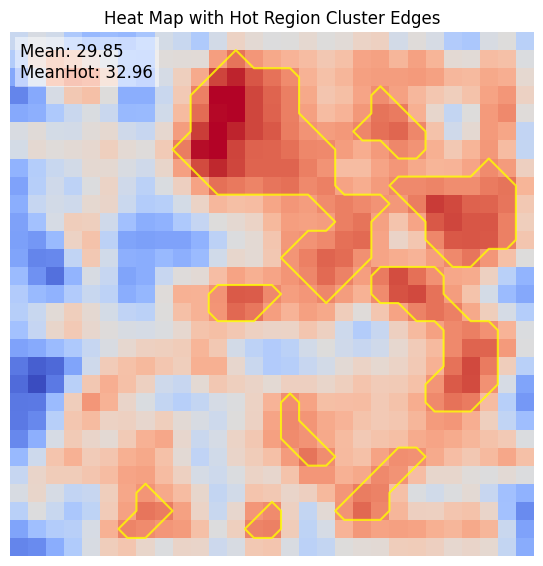

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Heat Map with Hot Region Cluster Edges'}>)

In [218]:
generate_heat_island_map(temp_matrix, temp_matrix, threshold=32, show=True)


## Single Run

Random run

In [219]:
random_solution = random_insertion(type_matrix, budget_max)

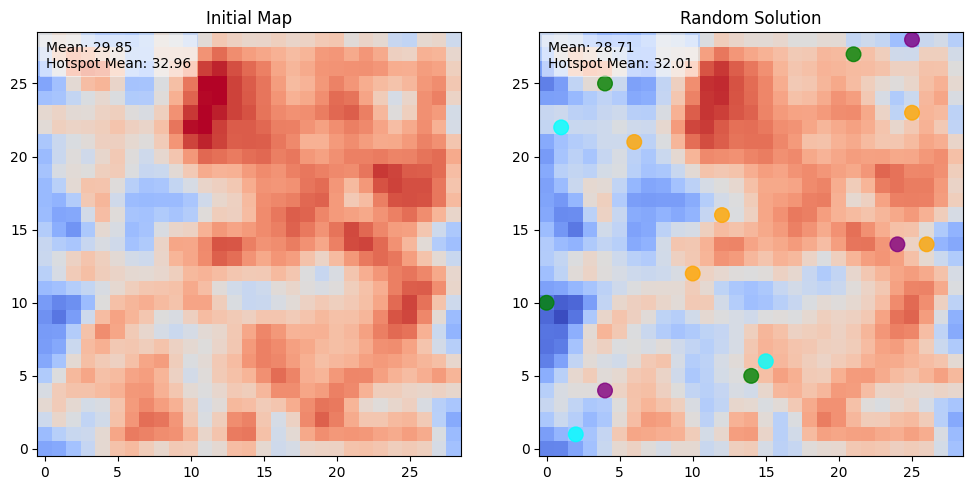

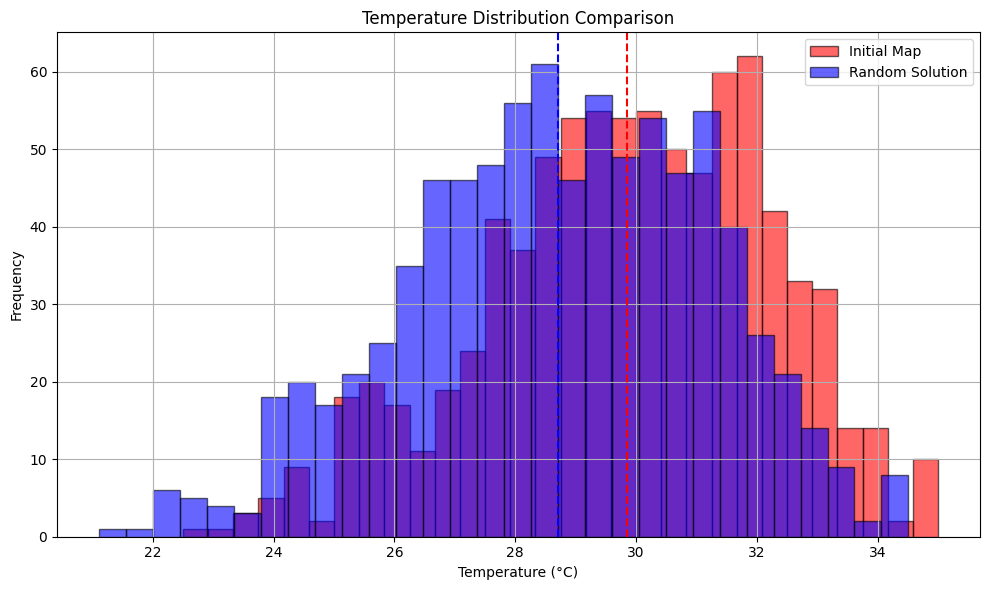

In [258]:
compare_solution_heatmaps([], random_solution, temp_matrix, tree_species,
                          title1="Initial Map", title2="Random Solution")


GA RUN

 The best solution found:                                                                           
 [15. 19.  0.  1.  1. 23.  2.  1. 11. 22.  2.  0.  2. 25.  3.  0.  1.  9.
  3.  0. 26. 16.  1.  1.  0. 15.  2.  0.  9. 20.  1.  0.  5. 14.  2.  0.
 12.  9.  3.  0.  0. 26.  3.  0.  1. 20.  2.  1.  2. 18.  2.  0.  6.  5.
  1.  1.  1. 18.  0.  0. 22.  2.  1.  1. 11. 21.  1.  1.  9. 16.  3.  0.
  2. 17.  1.  0.  1.  6.  2.  0.  8.  5.  3.  0. 12. 20.  1.  0. 11. 17.
  0.  1. 26.  1.  3.  0. 17. 22.  3.  0. 19.  8.  2.  0.  1. 25.  1.  0.
  9.  5.  1.  1. 10. 18.  1.  1. 10. 23.  0.  0. 28. 23.  3.  0.  0. 21.
  0.  0. 18.  2.  1.  0.  3.  9.  2.  0.  4. 14.  3.  0. 26. 13.  1.  0.
 17. 24.  0.  1. 10. 18.  0.  1.  1. 27.  0.  0.  6. 20.  1.  0. 21. 15.
  3.  0.  1. 11.  1.  1.  4. 26.  2.  0. 17.  9.  0.  1. 12. 17.  2.  0.
 18.  8.  2.  0. 16. 25.  1.  0. 21. 13.  3.  0. 27. 20.  3.  1. 27.  0.
  2.  1.]

 Objective function:
 47.31525564803805


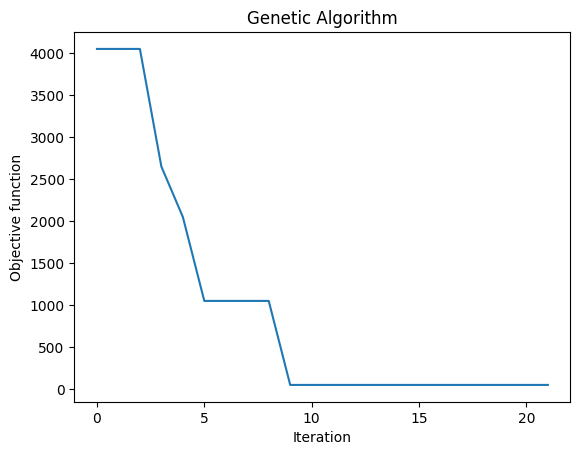

In [226]:
model = run_ga(type_matrix, temp_matrix, budget_max, type_to_num)

ga_solution = [(int(model.output_dict['variable'][i]), int(model.output_dict['variable'][i+1]), int(model.output_dict['variable'][i+2]))
               for i in range(0, len(model.output_dict['variable']), 4) if int(model.output_dict['variable'][i+3]) == 1]



In [228]:
print_solution_elements(ga_solution,heading='Single Run Result (25/75 Weighting)')
print("Total cost:", calculate_used_budget(ga_solution, type_matrix, tree_species, type_to_num))




--- Single Run Result (25/75 Weighting) ---
Number of placements: 16
Type: tree_1 at Position: (15, 19)
Type: tree_3 at Position: (1, 23)
Type: tree_2 at Position: (26, 16)
Type: tree_3 at Position: (1, 20)
Type: tree_2 at Position: (6, 5)
Type: tree_2 at Position: (22, 2)
Type: tree_2 at Position: (11, 21)
Type: tree_1 at Position: (11, 17)
Type: tree_2 at Position: (9, 5)
Type: tree_2 at Position: (10, 18)
Type: tree_1 at Position: (17, 24)
Type: tree_1 at Position: (10, 18)
Type: tree_2 at Position: (1, 11)
Type: tree_1 at Position: (17, 9)
Type: tree_4 at Position: (27, 20)
Type: tree_3 at Position: (27, 0)
Total cost: 1490.0


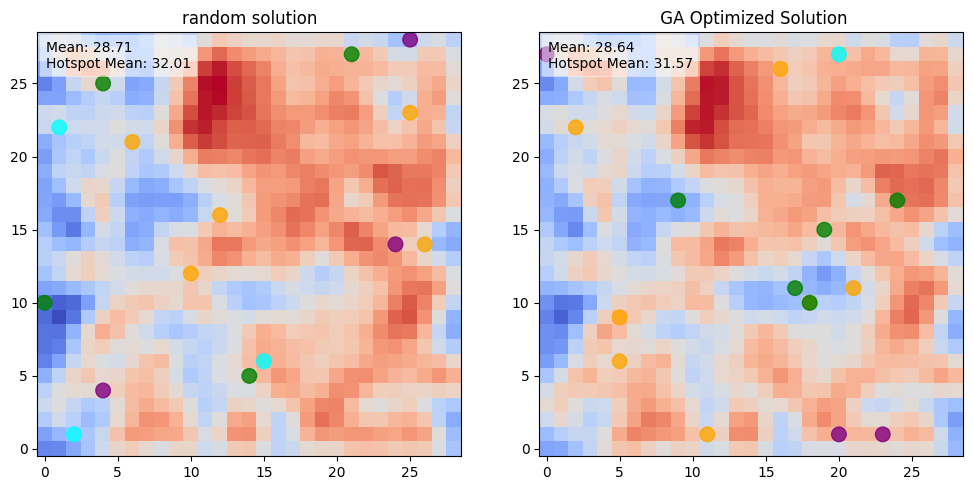

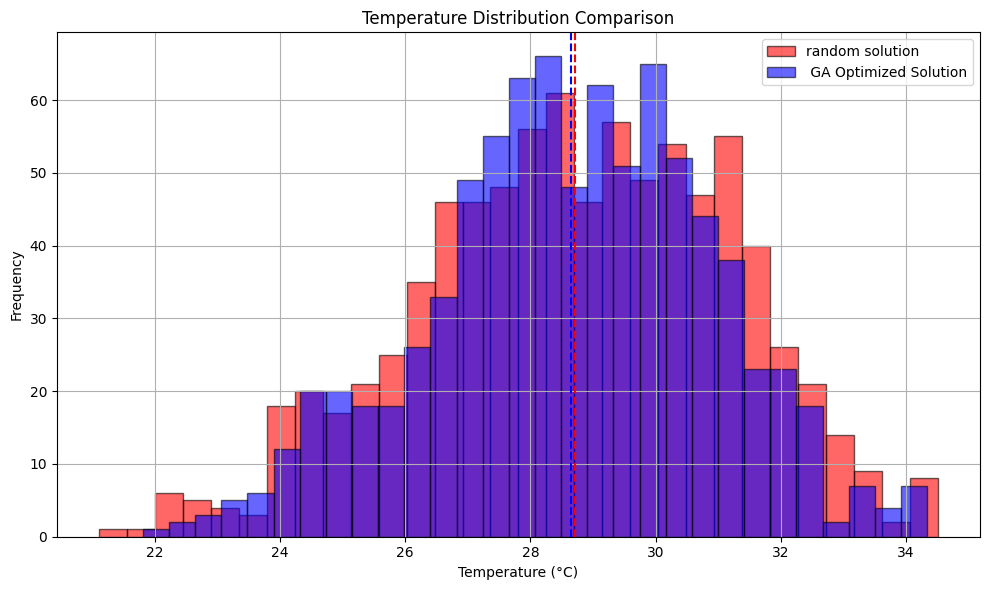

In [253]:
compare_solution_heatmaps(random_solution, ga_solution, temp_matrix, tree_species,
                          title1="random solution", title2=" GA Optimized Solution")


ACO RUN

In [237]:
aco_solution = run_aco(type_matrix, temp_matrix, type_to_num, budget_max, iterations=100, num_ants=10)


In [238]:
print_solution_elements(aco_solution, heading='ACO Result')
print("Total cost:", calculate_used_budget(aco_solution, type_matrix, tree_species, type_to_num))
aco_heatmap = calculate_reduced_heatmap(aco_solution, temp_matrix, tree_species)


--- ACO Result ---
Number of placements: 17
Type: tree_4 at Position: (3, 18)
Type: tree_1 at Position: (17, 20)
Type: tree_1 at Position: (24, 0)
Type: tree_2 at Position: (28, 6)
Type: tree_2 at Position: (16, 5)
Type: tree_2 at Position: (13, 1)
Type: tree_1 at Position: (24, 6)
Type: tree_4 at Position: (3, 5)
Type: tree_2 at Position: (1, 17)
Type: tree_1 at Position: (11, 13)
Type: tree_2 at Position: (22, 13)
Type: tree_2 at Position: (19, 19)
Type: tree_1 at Position: (0, 18)
Type: tree_4 at Position: (5, 26)
Type: tree_1 at Position: (12, 6)
Type: tree_1 at Position: (6, 16)
Type: tree_1 at Position: (6, 4)
Total cost: 1500.0


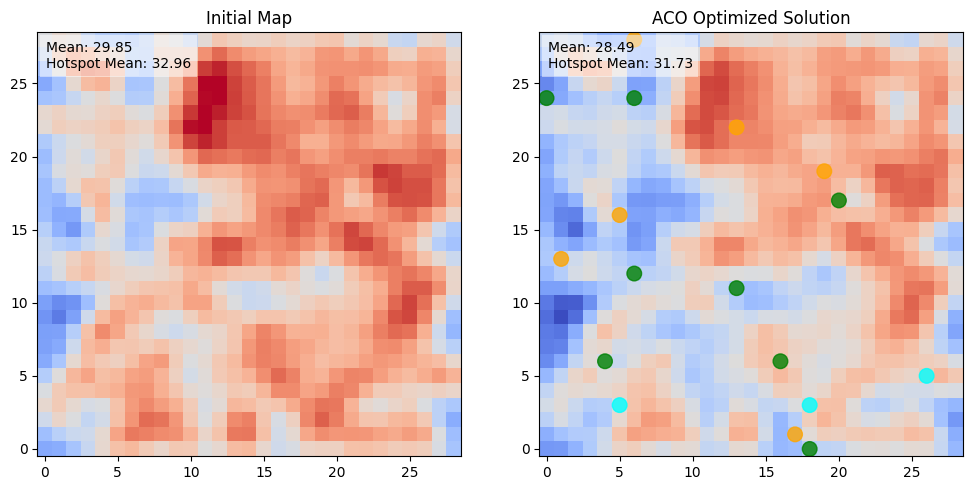

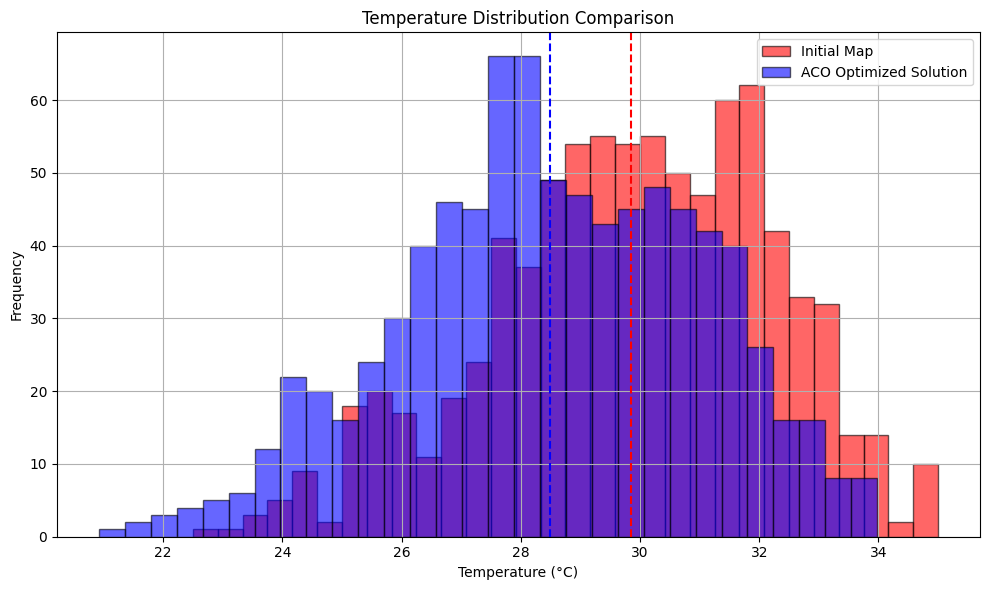

In [254]:
compare_solution_heatmaps([], aco_solution, temp_matrix, tree_species,
                          title1="Initial Map", title2="ACO Optimized Solution")


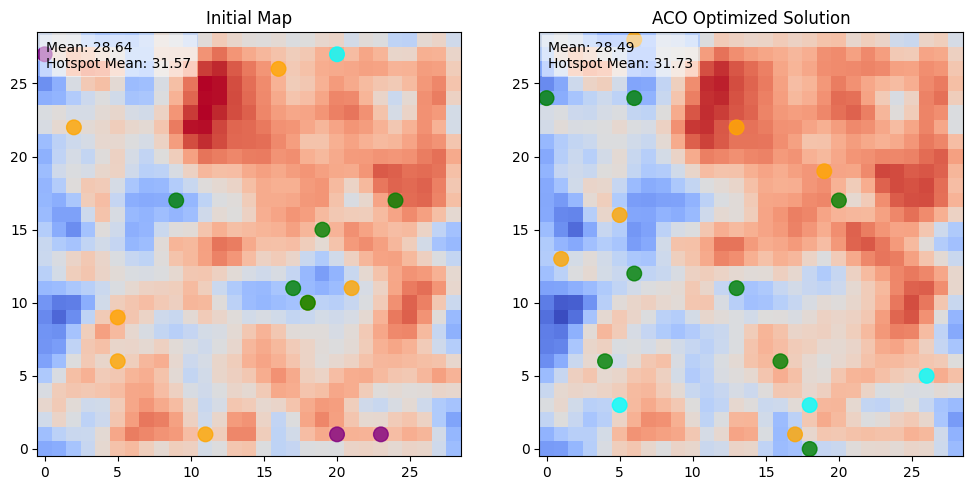

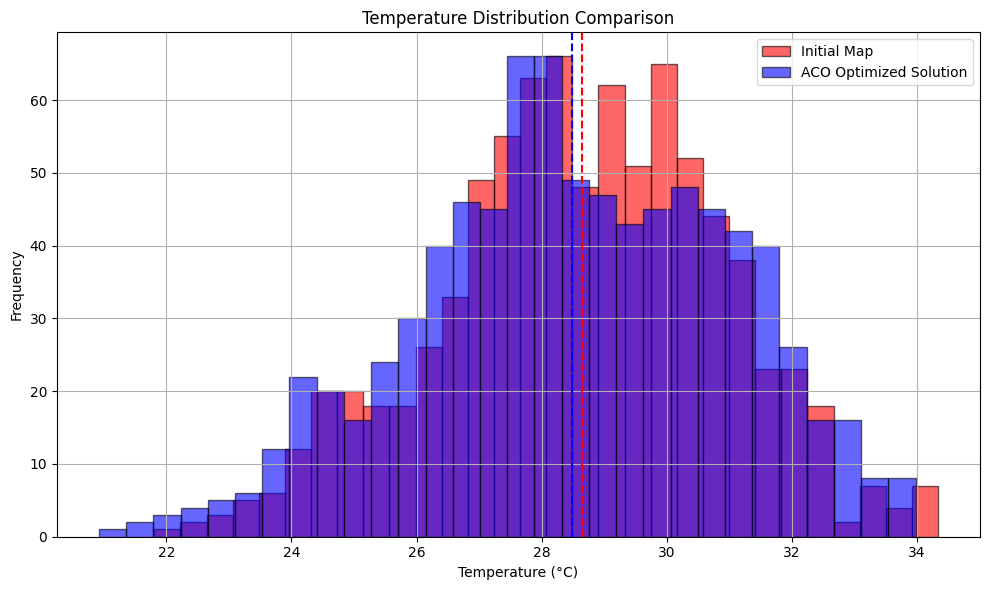

In [255]:
# Plot comparison of temperature maps for GA and ACO solutions
compare_solution_heatmaps(ga_solution, aco_solution, temp_matrix, tree_species,
                          title1="Initial Map", title2="ACO Optimized Solution")



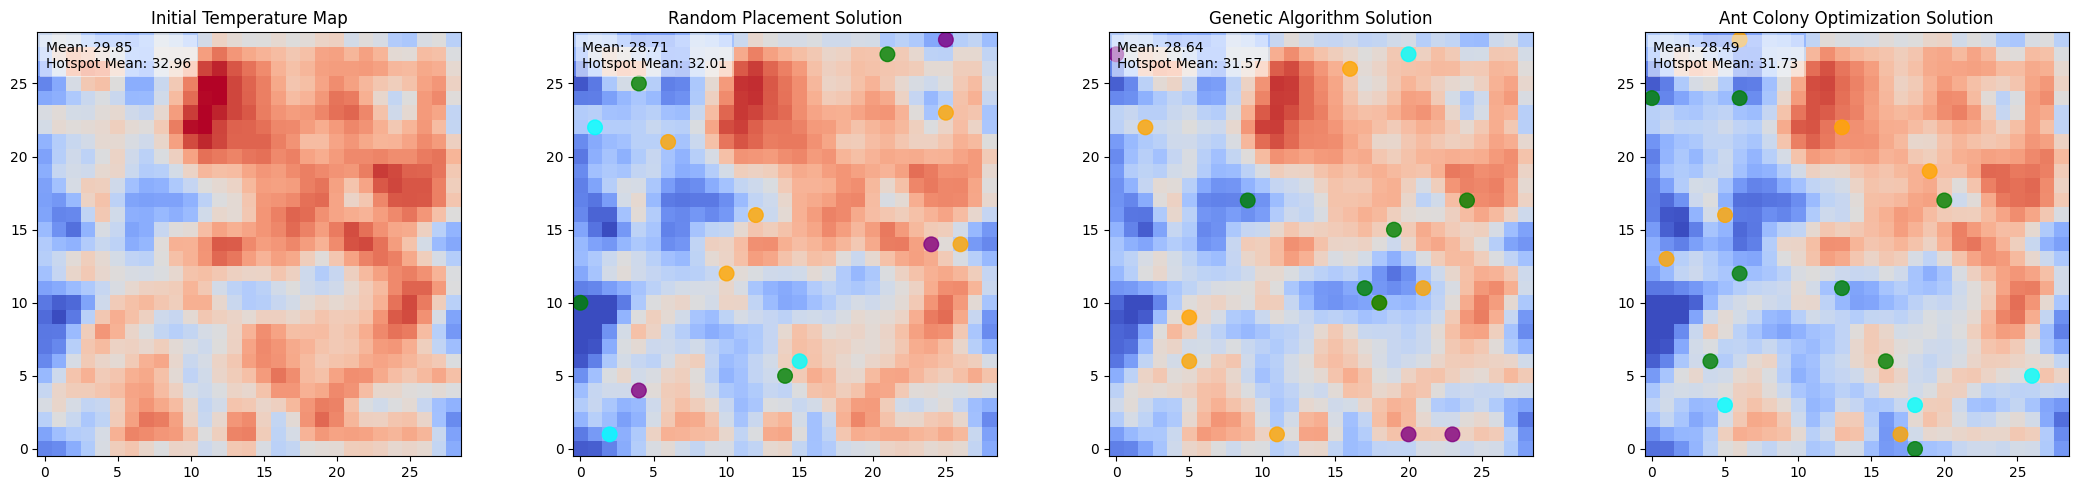

In [240]:
# Plot comparison of temperature maps for initial, random, GA, and ACO solutions
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Initial temperature map
generate_heatmap(temp_matrix, vmin=vmin, vmax=vmax, show=False, ax=axs[0])
avg_temp, avg_hotspot_temp = calculate_objective_stats(temp_matrix, temp_matrix)
axs[0].set_title("Initial Temperature Map")
axs[0].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[0].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Random solution temperature map
random_temp = calculate_reduced_heatmap(random_solution, temp_matrix, tree_species)
generate_heatmap(random_temp, vmin=vmin, vmax=vmax, show=False, ax=axs[1])
avg_temp, avg_hotspot_temp = calculate_objective_stats(random_temp, temp_matrix)
axs[1].set_title("Random Placement Solution")
axs[1].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[1].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for (row, col, species) in random_solution:
    axs[1].add_patch(plt.Circle((col, row), radius=0.5, color=tree_species[species]['color'], alpha=0.8))

# GA solution temperature map
ga_temp = calculate_reduced_heatmap(ga_solution, temp_matrix, tree_species)
generate_heatmap(ga_temp, vmin=vmin, vmax=vmax, show=False, ax=axs[2])
avg_temp, avg_hotspot_temp = calculate_objective_stats(ga_temp, temp_matrix)
axs[2].set_title("Genetic Algorithm Solution")
axs[2].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[2].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for (row, col, species) in ga_solution:
    axs[2].add_patch(plt.Circle((col, row), radius=0.5, color=tree_species[species]['color'], alpha=0.8))

# ACO solution temperature map
aco_temp = calculate_reduced_heatmap(aco_solution, temp_matrix, tree_species)
generate_heatmap(aco_temp, vmin=vmin, vmax=vmax, show=False, ax=axs[3])
avg_temp, avg_hotspot_temp = calculate_objective_stats(aco_temp, temp_matrix)
axs[3].set_title("Ant Colony Optimization Solution")
axs[3].text(0.02, 0.98, f"Mean: {avg_temp:.2f}\nHotspot Mean: {avg_hotspot_temp:.2f}",
            transform=axs[3].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
for (row, col, species) in aco_solution:
    axs[3].add_patch(plt.Circle((col, row), radius=0.5, color=tree_species[species]['color'], alpha=0.8))

plt.tight_layout()
plt.show()


# Multi-Run comparison


--- Run 1 ---
 The best solution found:                                                                           
 [27. 15.  3.  0. 28.  0.  3.  0. 17. 12.  3.  0. 16. 19.  1.  1.  8.  7.
  1.  0. 16.  6.  1.  0. 19. 17.  1.  0.  9.  3.  0.  0. 20. 25.  2.  0.
 14. 16.  0.  1.  0. 20.  1.  0. 27. 11.  3.  0.  2. 20.  1.  0. 18. 11.
  3.  0.  1. 20.  2.  0.  9. 19.  0.  0. 20.  6.  1.  1.  2.  1.  3.  1.
 13. 10.  0.  0. 23.  2.  2.  0.  8. 15.  1.  0.  9. 28.  3.  0. 18.  5.
  0.  1. 22.  8.  0.  0. 28.  4.  3.  1.  6. 10.  1.  1. 24. 21.  1.  0.
  4. 23.  0.  1.  8. 10.  1.  1.  8. 16.  0.  0. 14. 13.  3.  0. 28.  7.
  3.  0.  5. 20.  1.  0. 27.  8.  1.  0.  1.  4.  1.  1. 12.  2.  3.  1.
  7. 24.  2.  0. 25. 22.  2.  1.  0. 20.  1.  1. 11. 26.  0.  0. 20.  0.
  0.  1.  9. 23.  1.  0. 12.  1.  1.  0. 10. 18.  3.  0.  1. 18.  0.  0.
  4. 26.  1.  1. 24.  0.  2.  1. 15. 11.  3.  0. 23.  3.  2.  0.  1. 26.
  0.  0.]

 Objective function:
 47.31525564803805


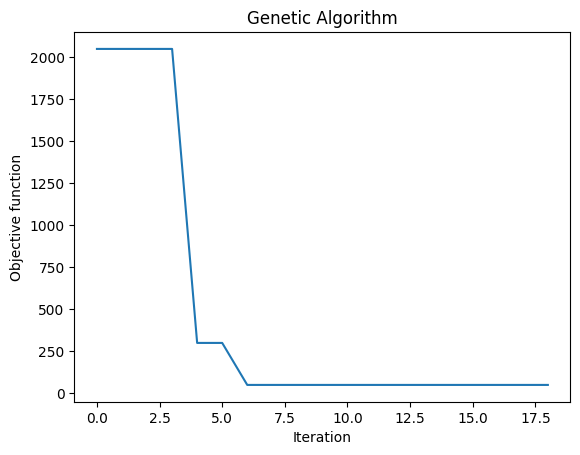


--- Run 2 ---
 The best solution found:                                                                           
 [27.  6.  2.  0. 25.  8.  3.  0. 28.  9.  2.  0. 17. 18.  0.  0.  6.  5.
  2.  0. 21. 16.  1.  0.  5. 24.  1.  0.  9.  6.  2.  0. 26. 10.  0.  0.
  8. 14.  1.  0.  6.  2.  2.  1. 15. 26.  2.  0. 15. 11.  3.  0. 23. 11.
  0.  0. 23.  4.  1.  1. 19. 14.  1.  0.  8. 25.  1.  0. 23. 28.  3.  1.
  3. 10.  1.  0. 10. 12.  3.  0. 19. 16.  3.  0. 11. 18.  2.  0.  2.  0.
  0.  1.  3. 11.  0.  0.  4. 21.  0.  0. 19. 12.  2.  1. 27.  1.  0.  0.
 13. 14.  0.  1.  7. 14.  3.  0.  1.  2.  0.  1. 23. 28.  1.  1. 11.  0.
  0.  1. 15.  3.  0.  1.  0. 19.  3.  0. 24. 14.  0.  0. 11. 14.  3.  1.
 27. 21.  1.  1.  6. 23.  3.  0. 14. 11.  1.  0. 22. 27.  3.  0. 23.  2.
  0.  0. 19.  8.  1.  0. 13. 18.  0.  0. 15.  6.  0.  0.  8. 28.  1.  1.
 20.  7.  1.  1.  7. 26.  1.  1.  6.  9.  2.  0. 17.  0.  1.  1.  5. 19.
  0.  0.]

 Objective function:
 47.31525564803805


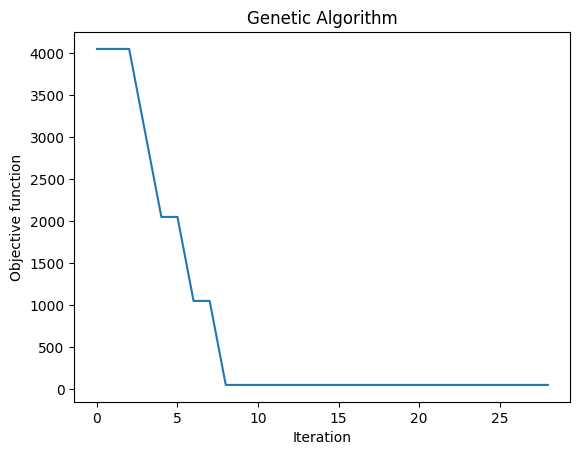


--- Run 3 ---
 The best solution found:                                                                           
 [23. 26.  3.  0.  8. 22.  3.  0. 24. 16.  3.  0. 15.  6.  3.  0.  6. 24.
  3.  0. 17. 17.  1.  0. 26. 23.  3.  0. 13.  9.  1.  0. 19.  9.  1.  1.
 24. 14.  2.  1.  3. 16.  0.  0.  7.  5.  3.  0. 26.  4.  0.  0.  1. 25.
  1.  0. 10. 16.  0.  1. 15. 18.  3.  0. 12. 19.  1.  1.  9. 28.  2.  0.
 27.  6.  3.  0. 10.  2.  2.  0.  4. 27.  3.  0. 17.  2.  2.  0.  5. 18.
  3.  1.  8.  9.  2.  1. 11. 23.  0.  1. 23. 25.  2.  1.  6. 24.  0.  0.
  6. 19.  1.  0.  9. 22.  2.  0.  2. 26.  1.  0.  9.  8.  2.  1. 28.  1.
  1.  0. 24. 23.  3.  1.  0.  9.  1.  0. 12. 19.  0.  0. 11. 11.  3.  1.
 17.  5.  0.  0.  6. 21.  1.  1.  0. 12.  3.  0. 10. 19.  1.  0. 17. 17.
  2.  0.  5. 16.  3.  0.  8.  9.  2.  0.  3. 23.  0.  1. 28. 26.  3.  0.
 28. 25.  0.  0. 19. 20.  0.  1. 13. 12.  1.  0. 13. 17.  0.  0. 22.  1.
  0.  0.]

 Objective function:
 47.320011890606416


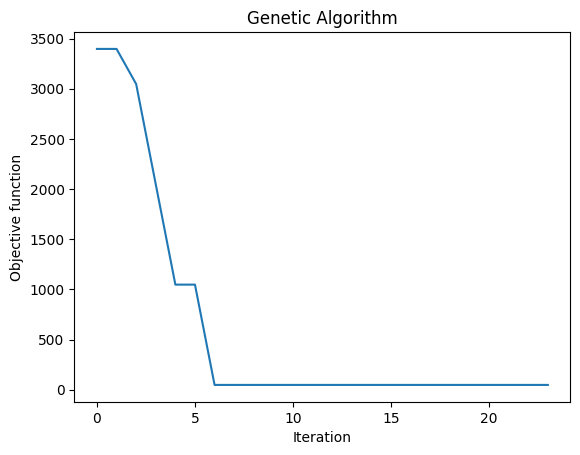


--- Run 4 ---
 The best solution found:                                                                           
 [ 3. 28.  1.  0. 27. 13.  3.  0.  2. 19.  0.  0.  6.  1.  3.  0.  3. 11.
  3.  0.  8. 14.  1.  0. 15. 19.  0.  0. 16.  4.  0.  0.  8. 20.  1.  0.
  8. 18.  3.  0. 10. 12.  2.  1. 28.  5.  0.  0.  9. 17.  1.  1. 28. 28.
  0.  0. 10.  3.  2.  1. 11. 20.  1.  0. 23.  8.  2.  1.  1. 23.  3.  0.
  0.  9.  1.  0. 17. 12.  0.  0. 14. 18.  2.  1.  5.  9.  3.  0.  4.  6.
  1.  0.  2. 24.  0.  0. 17. 15.  1.  1. 21. 18.  1.  1. 26. 25.  2.  1.
 16.  7.  0.  0. 12. 17.  3.  0. 19. 21.  0.  1.  0. 24.  2.  0. 11. 16.
  0.  1. 26.  3.  2.  0. 13.  9.  1.  0. 27. 27.  3.  0. 26. 27.  1.  0.
  8.  1.  0.  1. 19.  3.  0.  1. 17. 15.  0.  1. 15.  3.  0.  0. 15. 11.
  0.  0.  4. 12.  1.  1. 23.  1.  2.  0.  9.  6.  0.  0. 19. 22.  0.  0.
 17. 25.  1.  0. 11. 24.  2.  0. 15. 28.  3.  1. 14. 13.  0.  0.  2.  3.
  0.  1.]

 Objective function:
 47.31525564803805


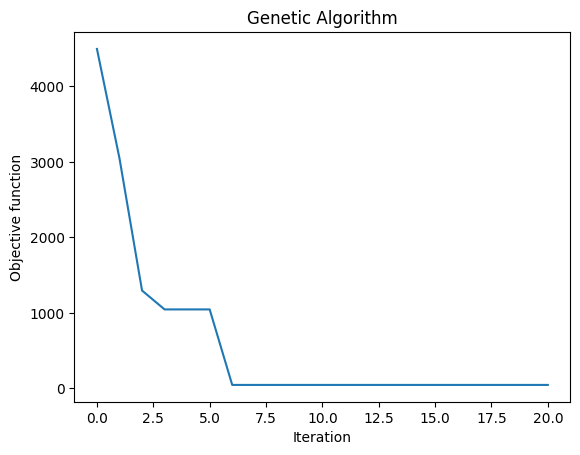


--- Run 5 ---
 The best solution found:                                                                           
 [ 2.  3.  0.  0.  7. 24.  2.  1. 17.  1.  2.  0. 24.  2.  1.  0.  1.  8.
  0.  0.  9.  6.  2.  1. 20.  1.  3.  0.  4.  1.  0.  0. 26.  8.  2.  0.
 24.  6.  1.  0. 10. 17.  0.  1.  5. 17.  2.  0. 13. 10.  1.  1.  3.  5.
  3.  0. 18.  6.  2.  1.  3. 11.  2.  0. 22. 13.  0.  0. 18. 18.  1.  0.
  3. 17.  3.  0. 20.  1.  2.  0.  2. 11.  0.  0. 21. 13.  1.  0. 14. 27.
  3.  1. 20. 14.  2.  0. 21.  4.  3.  0.  1. 22.  1.  1. 11. 22.  2.  0.
  6. 12.  1.  0.  3. 17.  1.  0.  5. 23.  3.  0. 16.  2.  1.  1. 14.  0.
  3.  0. 18.  1.  0.  0. 13. 15.  1.  0. 26.  0.  0.  1. 27. 20.  1.  0.
 20. 10.  3.  0. 19. 28.  0.  1. 28.  7.  2.  0. 11. 16.  1.  0.  5. 13.
  1.  0.  0. 11.  2.  1. 17.  4.  1.  0. 24. 19.  1.  0. 22.  2.  0.  0.
 25.  6.  2.  1. 12. 13.  0.  1.  0. 20.  1.  1.  8.  7.  0.  1. 19.  9.
  0.  1.]

 Objective function:
 47.31525564803805


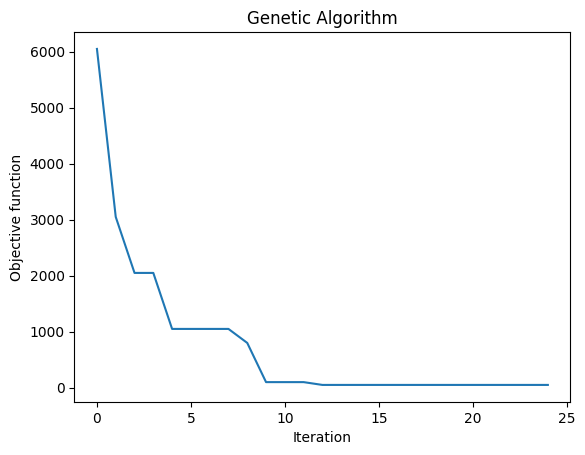


--- Run 6 ---
 The best solution found:                                                                           
 [11.  6.  2.  1.  5.  9.  0.  1. 11.  7.  3.  0. 21. 17.  1.  0. 15. 18.
  3.  0. 21. 17.  2.  0.  7. 26.  1.  1. 25.  3.  3.  0. 16. 16.  0.  1.
 25. 14.  2.  1. 21. 15.  0.  0. 21. 21.  1.  0. 24. 18.  1.  1.  4. 26.
  2.  0.  6. 10.  0.  0. 20.  3.  1.  1. 22. 25.  1.  0.  1. 13.  0.  0.
  6. 17.  3.  0. 26.  6.  0.  0.  4. 13.  1.  0. 21.  2.  1.  0. 22. 14.
  0.  0. 19. 13.  3.  1.  0. 23.  0.  0.  2. 13.  1.  0. 10.  1.  1.  1.
 13. 24.  3.  0. 24. 12.  1.  0. 27.  6.  1.  0. 17.  2.  3.  0. 14. 27.
  2.  1. 28. 27.  1.  1. 23. 27.  0.  0. 10.  4.  1.  1. 10.  3.  2.  0.
 18. 12.  0.  1.  3. 13.  1.  1. 15. 12.  0.  0. 14.  6.  3.  0. 19.  1.
  1.  0. 16. 19.  0.  1.  5.  7.  1.  0. 14. 12.  0.  0. 16. 11.  0.  0.
  6. 26.  1.  0.  3. 16.  2.  1. 18.  6.  0.  0. 21. 17.  1.  0.  3.  2.
  1.  1.]

 Objective function:
 47.312877526753866


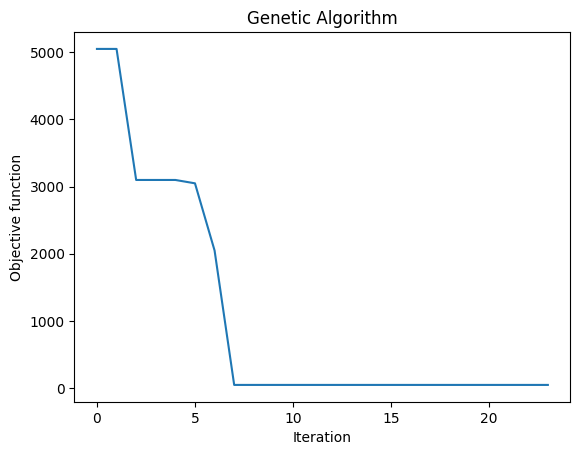


--- Run 7 ---
 The best solution found:                                                                           
 [ 6. 19.  0.  0.  7. 17.  0.  0.  4. 19.  0.  0.  4.  4.  2.  1. 19. 10.
  2.  1. 17. 28.  1.  0. 13. 20.  2.  0.  0. 22.  1.  0. 15. 12.  2.  0.
 28. 23.  1.  0. 14. 11.  1.  0. 12. 14.  2.  0. 17. 28.  1.  0.  8.  4.
  3.  0. 15. 14.  0.  1. 11. 26.  1.  0.  4.  9.  3.  1. 18. 13.  0.  0.
 21.  0.  2.  0.  3. 21.  1.  0.  8.  7.  0.  1. 12. 20.  2.  0. 24.  3.
  2.  0. 13. 17.  0.  0.  5. 28.  2.  0.  9. 22.  2.  1. 27. 28.  0.  0.
  4. 12.  2.  1.  0. 21.  0.  1. 12. 18.  0.  1. 26.  7.  1.  1. 20. 16.
  3.  0. 20. 27.  3.  0. 12.  2.  0.  0. 17. 17.  0.  0. 11.  5.  2.  0.
  9. 28.  0.  1. 25.  2.  3.  0. 10. 27.  0.  0.  7.  2.  2.  1. 18.  1.
  0.  1. 21.  7.  0.  1. 10.  4.  1.  0. 11. 12.  3.  1. 26. 16.  2.  0.
 16.  9.  0.  1. 25. 19.  1.  0.  5.  9.  2.  0. 14. 13.  2.  0. 21.  0.
  2.  0.]

 Objective function:
 47.31525564803805


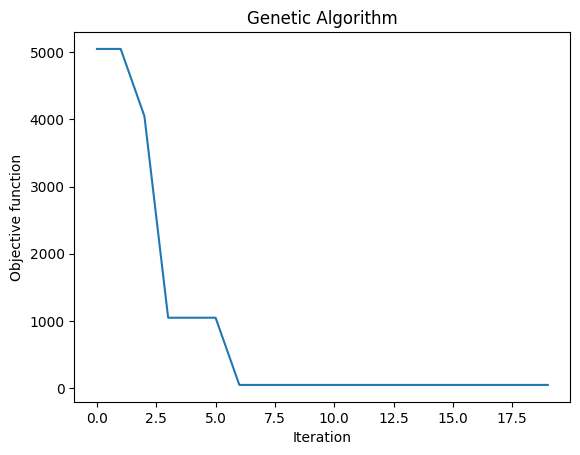


--- Run 8 ---
 The best solution found:                                                                           
 [24.  4.  2.  1. 21. 26.  3.  1. 20. 16.  3.  0. 23. 22.  0.  0.  0. 19.
  3.  1.  7.  2.  2.  0. 17.  5.  2.  0. 26.  7.  0.  0. 11.  2.  2.  0.
 11. 11.  2.  0. 12. 17.  3.  0. 18. 18.  1.  0.  4. 26.  2.  0.  5. 24.
  1.  0. 14.  3.  1.  1. 28. 28.  2.  1. 24. 10.  3.  0.  2. 14.  3.  0.
 16. 18.  1.  0. 22. 15.  0.  0.  6. 23.  3.  0.  0. 26.  1.  0.  1. 14.
  0.  0.  6.  0.  1.  1. 14. 12.  2.  0.  7. 26.  0.  1. 28. 17.  1.  0.
  2. 12.  0.  1. 22.  1.  2.  0. 21. 24.  0.  1.  9. 17.  1.  1. 24.  7.
  2.  1. 24. 21.  1.  0.  9. 27.  1.  0. 18. 18.  1.  1. 23.  5.  3.  0.
  7. 17.  2.  0. 11. 15.  0.  1.  3. 25.  0.  0. 20.  0.  3.  0. 12. 17.
  2.  0.  4. 26.  0.  0. 14. 15.  2.  0. 21. 10.  2.  0. 24. 23.  0.  1.
  2. 23.  1.  0.  4.  0.  1.  1. 28.  4.  3.  1. 23. 10.  0.  0. 28. 25.
  0.  1.]

 Objective function:
 47.312877526753866


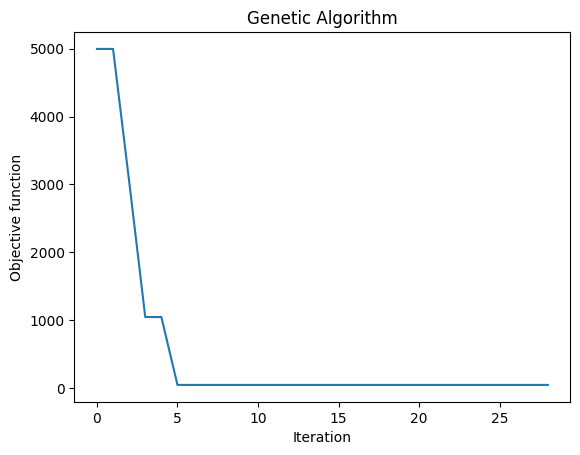


--- Run 9 ---
 The best solution found:                                                                           
 [24.  4.  1.  1. 17.  7.  1.  0. 22. 25.  1.  0. 13. 13.  3.  0. 16.  1.
  0.  1.  2.  6.  2.  0.  8.  1.  0.  0. 19. 27.  2.  0.  5. 12.  2.  0.
  0. 25.  0.  0.  4. 19.  0.  0. 27. 27.  1.  0. 15.  8.  0.  1. 19. 12.
  3.  0.  5. 26.  2.  0.  2.  4.  0.  1. 17. 22.  0.  1. 20. 28.  3.  0.
 11. 25.  0.  0.  7. 26.  0.  1.  5.  9.  0.  1. 26. 23.  3.  0. 23.  3.
  0.  1.  6.  6.  2.  0. 16. 21.  0.  1.  8.  8.  2.  0.  0. 28.  0.  1.
 24.  7.  1.  0. 19. 25.  2.  1. 23.  9.  1.  0.  8. 17.  2.  0.  7. 26.
  2.  0.  5. 19.  0.  0. 13. 10.  0.  1.  0. 16.  0.  0.  3. 10.  2.  0.
  2. 18.  3.  0. 24.  9.  3.  1. 28. 21.  0.  1. 13.  1.  1.  0. 14. 11.
  3.  0.  4. 22.  2.  0. 27. 18.  0.  0. 18. 17.  0.  1. 10.  3.  0.  0.
 19.  1.  3.  0. 25. 18.  3.  0.  0. 23.  0.  1. 13. 15.  3.  1. 11.  1.
  2.  1.]

 Objective function:
 47.31049940546968


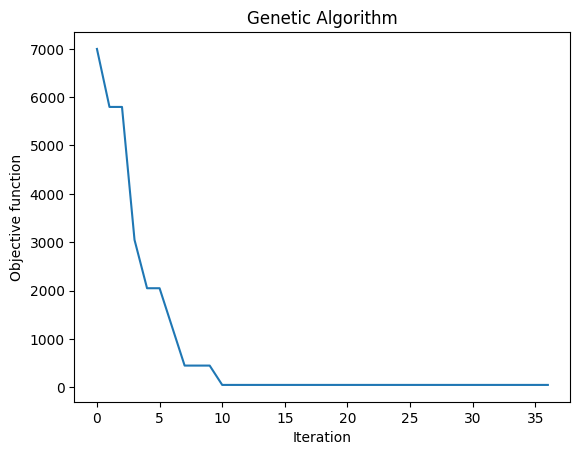


--- Run 10 ---
 The best solution found:                                                                           
 [ 6. 17.  3.  0. 17.  6.  2.  1. 21. 18.  1.  1. 13. 27.  3.  0. 19. 19.
  2.  0. 13. 20.  3.  1.  3. 21.  0.  1. 21. 14.  0.  0.  7. 10.  2.  0.
 16. 19.  3.  1.  3. 10.  3.  1. 19. 27.  2.  0. 17. 22.  2.  0.  5. 22.
  0.  0.  8.  8.  1.  1.  2.  4.  3.  1. 26. 15.  2.  0. 26.  1.  1.  0.
  7. 16.  0.  0. 19.  3.  1.  0. 13. 27.  3.  0.  3. 26.  2.  0.  4. 28.
  3.  0.  9. 12.  1.  0. 25. 19.  0.  1. 16. 14.  3.  0. 22.  3.  2.  0.
 10. 17.  1.  1. 24. 26.  2.  0. 13.  4.  2.  0. 28. 18.  0.  1. 11. 11.
  3.  0.  2. 27.  2.  1. 24.  7.  0.  0. 11.  4.  0.  1. 14. 13.  1.  0.
 12. 17.  0.  0.  0. 24.  3.  0.  4.  1.  1.  0.  6.  1.  1.  0.  4. 25.
  1.  0. 13. 18.  0.  0. 12.  0.  1.  0.  3. 14.  1.  0.  1. 19.  0.  0.
 10.  7.  1.  0. 15.  0.  2.  1. 19. 17.  3.  0. 11. 19.  2.  0. 27. 24.
  2.  1.]

 Objective function:
 47.31763376932223


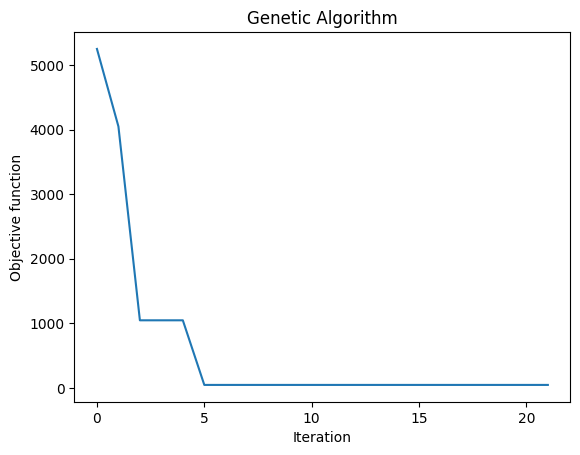

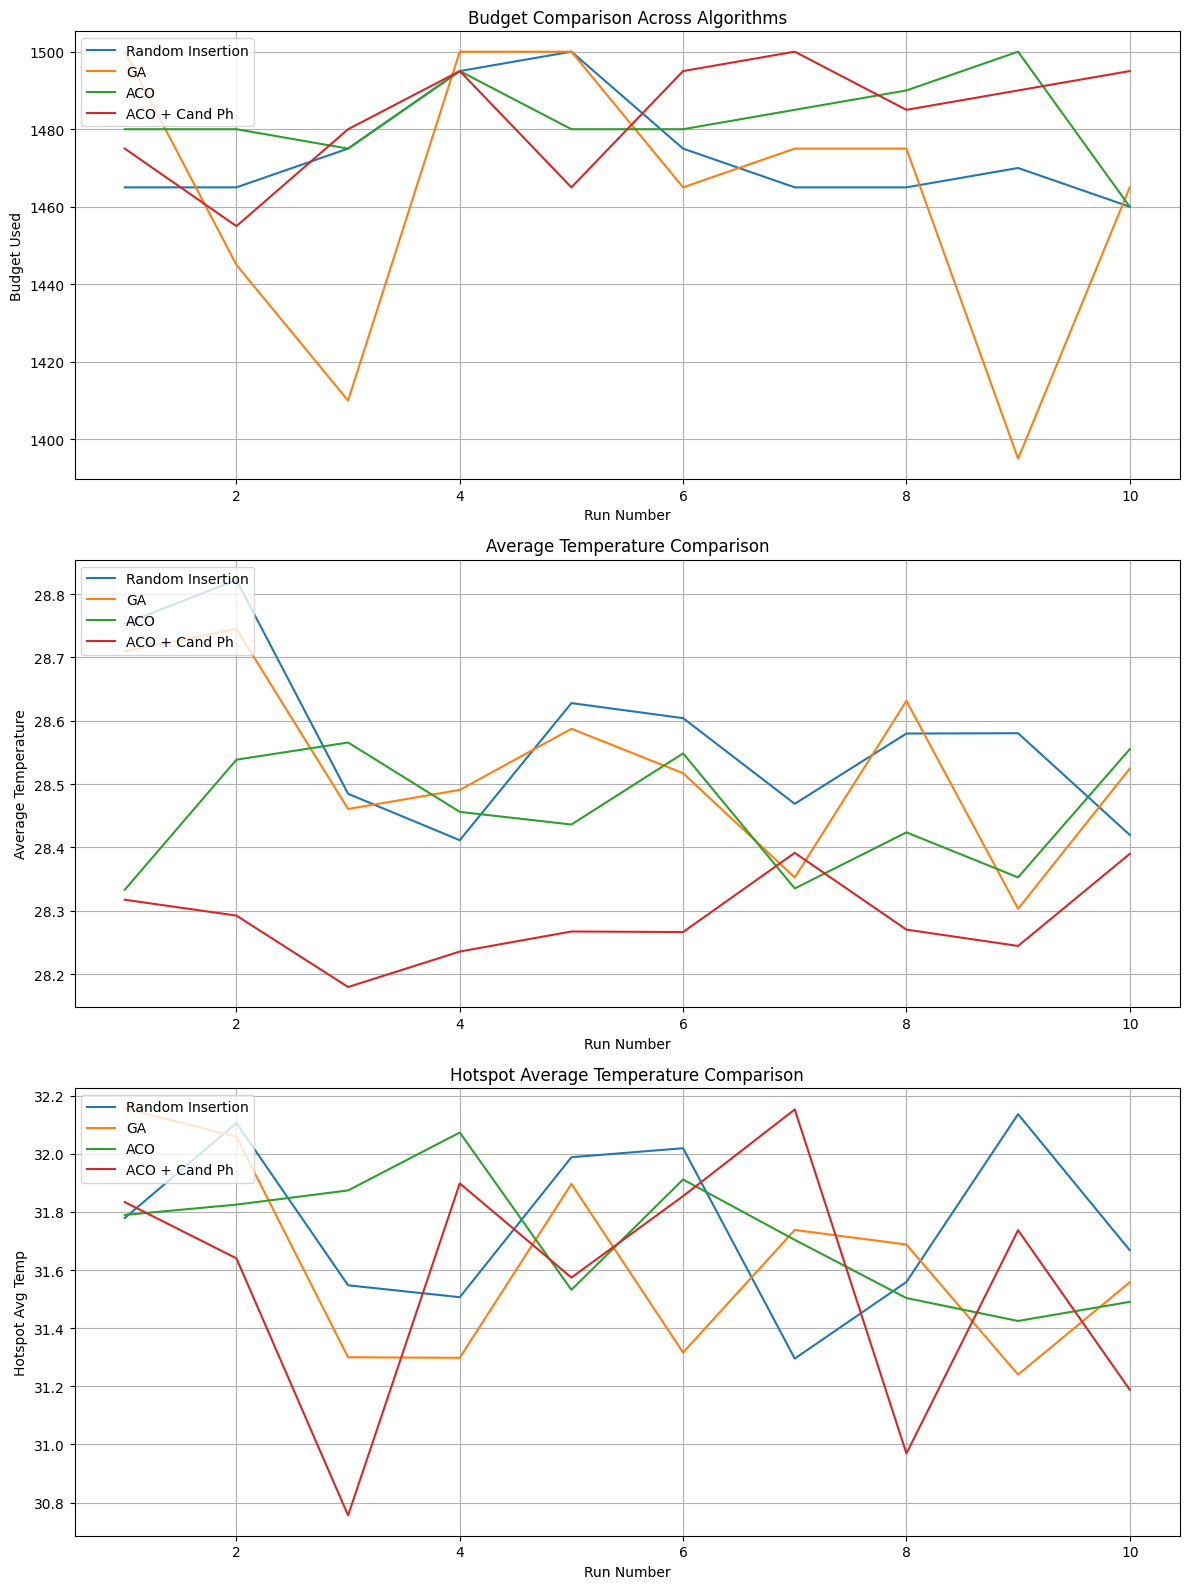

In [257]:
stats = evaluate_multiple_runs(runs=10, type_matrix=type_matrix, temp_matrix=temp_matrix,
                               budget_max=budget_max, type_to_num=type_to_num, tree_species=tree_species)



=== Summary Table ===
          Algorithm  Mean Budget  Std Budget  Mean Avg Temp  Std Avg Temp  \
0  Random Insertion       1473.5       12.85          28.58          0.13   
1                GA       1463.0       34.87          28.53          0.13   
2               ACO       1482.5       10.55          28.45          0.09   
3     ACO + Cand Ph       1483.5       13.97          28.29          0.06   

   Mean Hotspot Temp  Std Hotspot Temp  
0              31.76              0.27  
1              31.62              0.32  
2              31.71              0.21  
3              31.56              0.42  


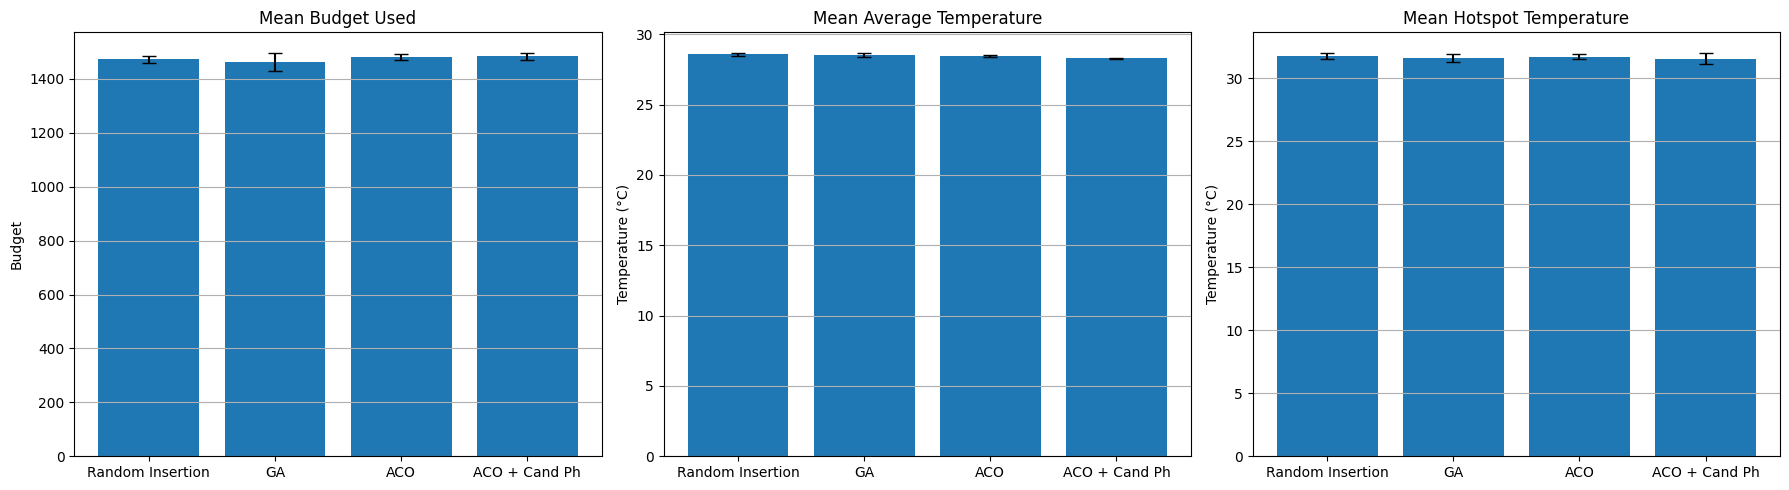

C:\Users\usuel\AppData\Local\Temp\ipykernel_20232\561464946.py:69: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot(budget_data, labels=algorithms)
C:\Users\usuel\AppData\Local\Temp\ipykernel_20232\561464946.py:76: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[1].boxplot(avg_temp_data, labels=algorithms)
C:\Users\usuel\AppData\Local\Temp\ipykernel_20232\561464946.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[2].boxplot(hotspot_temp_data, labels=algorithms)


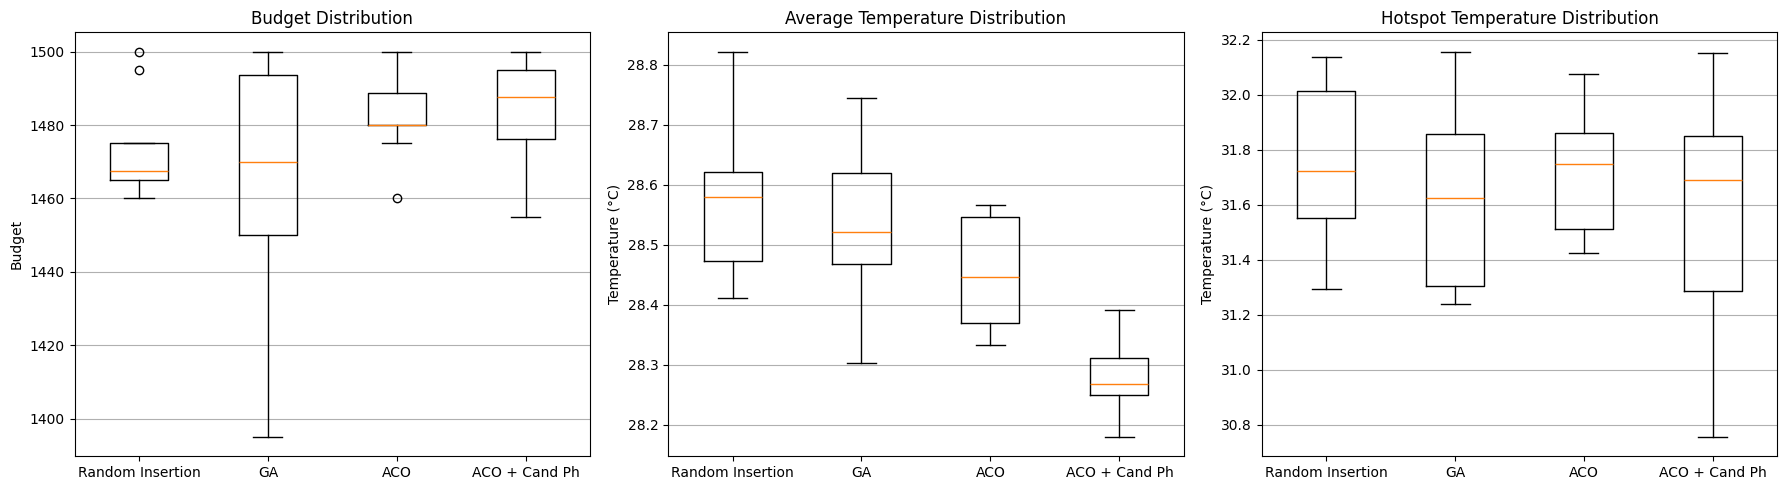


Summary exported to 'algorithm_comparison_summary.csv'


In [259]:
summary_df = summarize_algorithm_runs(stats, algorithms)
